In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [2]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [3]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

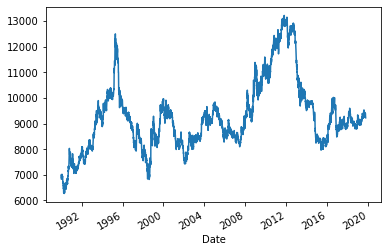

In [4]:
# Plot just the "Settle" column from the dataframe:
# YOUR CODE HERE!

yen_futures.Settle.plot()

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [9]:
import statsmodels.api as sm
df = yen_futures
yen_futures_noise, yen_futures_trend = sm.tsa.filters.hpfilter(df['Settle'])
# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
# YOUR CODE HERE!
df = yen_futures[["Settle"]].copy()


In [10]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
# YOUR CODE HERE!



df['Rolling15'] = df["Settle"].rolling(window=15).mean()
df['Rolling60'] = df["Settle"].rolling(window=60).mean()
df['RollingEWM'] = df["Settle"].ewm(halflife=15).mean()


df.head()

,Settle,Rolling15,Rolling60,RollingEWM
Date,,,,
1990-01-02,6847.0,NaN,NaN,6847.000000
1990-01-03,6887.0,NaN,NaN,6867.462016
1990-01-04,7008.0,NaN,NaN,6916.488648
1990-01-05,6950.0,NaN,NaN,6925.455821
1990-01-08,6959.0,NaN,NaN,6932.798551


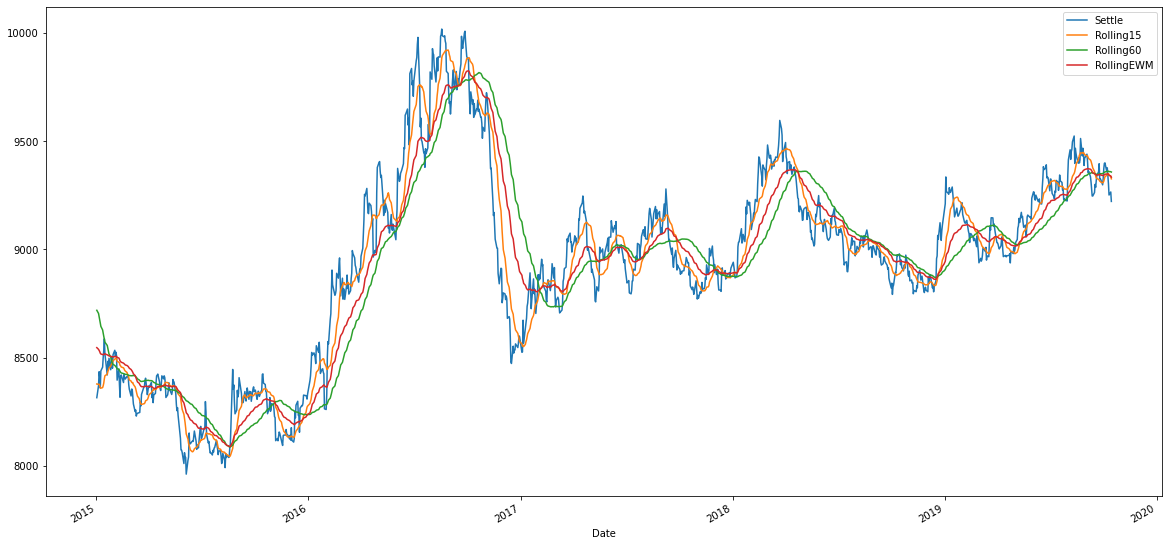

In [11]:
# Plot the Settle Price vs. the Trend for 2015 to the present
# YOUR CODE HERE!

df["2015":].plot(figsize=(20,10))

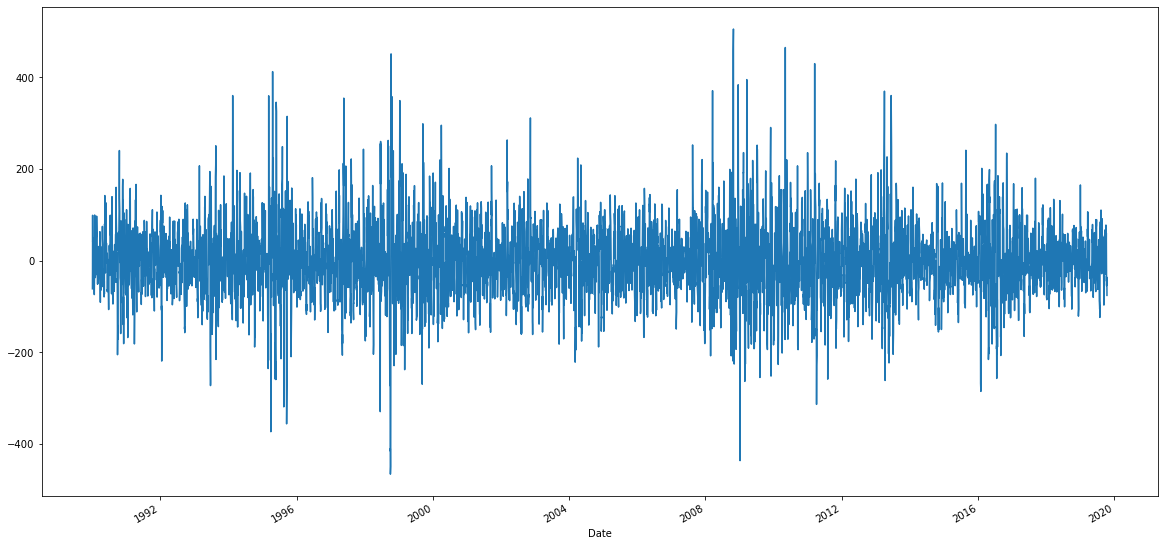

In [12]:
# Plot the Settle Noise
# YOUR CODE HERE!

yen_futures_noise.plot(figsize=(20,10))

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [13]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [14]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

# Estimate and ARMA model using statsmodels (use order=(2, 1))
# YOUR CODE HERE!

model = ARMA(returns.values, order=(2,1))

# Fit the model and assign it to a variable called results
# YOUR CODE HERE!

results = model.fit()


In [15]:
# Output model summary results:
# YOUR CODE HERE!

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Tue, 25 Aug 2020   AIC                          15798.142
Time:                        18:45:34   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.008      0.804      0.422      -0.009       0.022
ar.L1.y       -0.3060      1.278     -0.240      0.811      -2.810       2.198
ar.L2.y       -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.y        0.2944      1.278      0.230      0.818      -2.209       2.798
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3373           +0.0000j            3.3373            0.5000
AR.2         -157.2951           +0.0000j          157.2951            0.5000
MA.1           -3.3964           +0.0000j            3.3964            0.5000
-----------------------------------------------------------------------------
"""

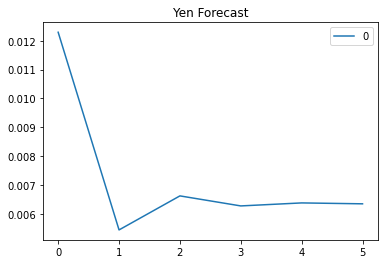

In [19]:
# Plot the 5 Day Returns Forecast
# YOUR CODE HERE!
pd.DataFrame(results.forecast(steps=6)[0]).plot(title="Yen Forecast")

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [95]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
# YOUR CODE HERE!
##df.index = pd.DatetimeIndex(df.index).to_period('M')
model = ARIMA(df['Settle'], order=(5, 1, 1))

##model = ARIMA(history.values.reshape(-1).tolist(), order=(2,1,2))
# Fit the model
# YOUR CODE HERE!

results = model.fit()

In [96]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.619
Method:                       css-mle   S.D. of innovations             64.281
Date:                Tue, 25 Aug 2020   AIC                          83905.238
Time:                        19:41:36   BIC                          83960.635
Sample:                    01-31-1990   HQIC                         83924.259
                         - 10-31-2019                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3160      0.700      0.451      0.652      -1.056       1.688
ar.L1.D.Settle     0.2822      0.699      0.404      0.687      -1.088       1.653
ar.L2.D.Settle     0.0007      0.016      0.043      0.966      -0.030       0.032
ar.L3.D.Settle    -0.0126      0.012     -1.032      0.302      -0.037       0.011
ar.L4.D.Settle    -0.0137      0.015     -0.889      0.374      -0.044       0.016
ar.L5.D.Settle    -0.0012      0.018     -0.064      0.949      -0.036       0.034
ma.L1.D.Settle    -0.2972      0.699     -0.425      0.671      -1.667       1.073
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8917           -1.3786j            2.3408           -0.1002
AR.2            1.8917           +1.3786j            2.3408            0.1002
AR.3           -2.2699           -3.0207j            3.7786           -0.3526
AR.4           -2.2699           +3.0207j            3.7786            0.3526
AR.5          -11.0656           -0.0000j           11.0656           -0.5000
MA.1            3.3648           +0.0000j            3.3648            0.0000
-----------------------------------------------------------------------------
"""

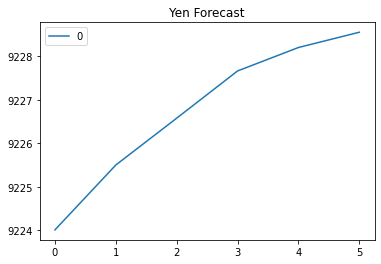

In [97]:
# Plot the 5 Day Price Forecast
# YOUR CODE HERE!
pd.DataFrame(results.forecast(steps=6)[0]).plot(title="Yen Forecast")

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [76]:
from arch import arch_model
import pandas_datareader.data as web
import datetime as dt


In [77]:
# Estimate a GARCH model:
# YOUR CODE HERE!

model = arch_model(returns, mean="Zero", vol="GARCH", p=1, q=1)
# Fit the model
# YOUR CODE HERE!

res = model.fit(disp="off")

In [78]:
# Summarize the model results
# YOUR CODE HERE!

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14929.9
Method:            Maximum Likelihood   BIC:                           14950.6
                                        No. Observations:                 7514
Date:                Tue, Aug 25 2020   Df Residuals:                     7511
Time:                        19:28:52   Df Model:                            3
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      4.2895e-03  1.798e-03      2.385  1.707e-02 [7.646e-04,7.814e-03]
alpha[1]       0.0381  8.773e-03      4.341  1.419e-05 [2.089e-02,5.528e-02]
beta[1]        0.9536  1.114e-02     85.623      0.000     [  0.932,  0.975]
============================================================================

Covariance estimator: robust
"""

In [79]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [80]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
# YOUR CODE HERE!
forecasts = res.forecast(start='2019-10-15', horizon=forecast_horizon)
forecasts

In [81]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2019-10-15,7.434026,7.475721,7.516842,7.5574,7.597407


In [82]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2019-10-15
h.1,7.434026
h.2,7.475721
h.3,7.516842
h.4,7.557400
h.5,7.597407


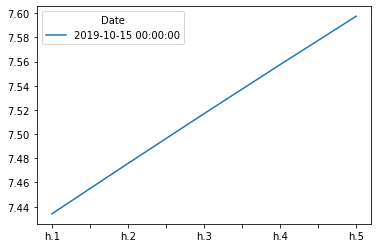

In [83]:
# Plot the final forecast
# YOUR CODE HERE!

final.plot()

---

# Conclusions

### Based on your time series analysis, would you buy the yen now?

   Based on the time series analysis there appears to be multiple years of consolidation. No - I think it is likely to continue to continue to decrease as the stock market rises.     Considering it's broken below the rolling 15,60, and EWM - I think it is likely to follow that trend. 

### Is the risk of the yen expected to increase or decrease?

   I think risk is expected to increase.  

    

### Based on the model evaluation, would you feel confident in using these models for trading?

   These markets on the surface are great but I need a better understand of how they work prior to me being able to answer this question. 
    